In [3]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2
from supplementary.simple_choice_model import hits_gen as hits
from supplementary.simple_choice_model import sim_tools

# Introduction
This notebook will introduce an artificial agent that uses a simple decision-making routine in order to choose the next task to interact with. The agent starts in some initial state (some past history of interacting with all tasks) to make the initial decision. Upon choosing a task, the agent "plays" it, gets some feedback (hit or miss), updates its state accordingly and repeats. This closed cyclical process involves multiple components that can produce different behaviors over time.

One interesting thing about the tasks that the agent chooses from, is that the probability of yielding a reward can change over time depending on the agent's engagement with the task. We can simulate this with any function that takes time (experience) for a given task as an argument and returns the probability of getting a reward. Below, I will use a sigmoid function of a linear function with 1 independent predictor: number of trials on task (so far). Basically:

$$ P(\text{hit} \mid \text{trial}) = \sigma(b_0 + b_1 \text{trial}) = \frac{1}{1 + e^{-(b_0 + b_1 \text{trial})}} $$

where $b_0, b_1$ are free parameters and can differ between tasks. Parameter $b_1$ corresponds to how rapidly the sigmoid increases and $b_0$ corresponds how likely getting a hit is without prior experience with the task. Below you have an interface to either fit these parameters to our data (or aspects of data), or tweak them as you like. Select the next code cell and run it (try `Shift + Enter`, or the Run button from the menu on the top left).

# Generating hits

<IPython.core.display.Javascript object>


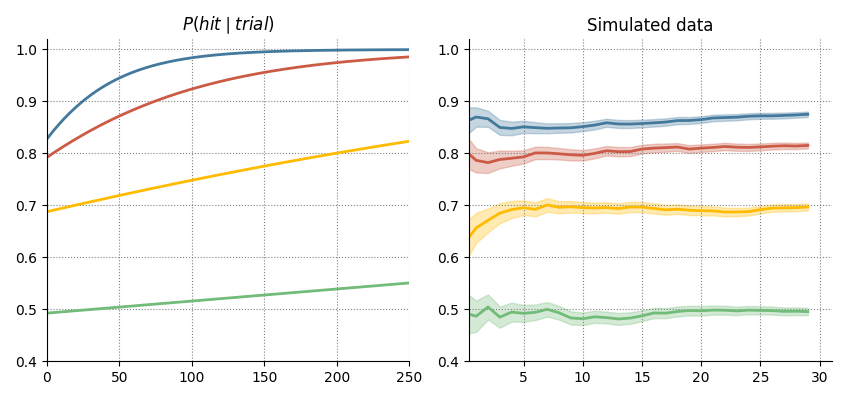

In [4]:
# %matplotlib notebook
# from supplementary.simple_choice_model import hits_gen as hits
hits_generator = hits.HitsGeneratorGUI(bandits=['1D','I1D','2D','R'])

# Simulation
With a fixed "hits generator" we can simulate a multi-task free play. The agent uses a linear utility function to evaluate each task:

$$ u(\text{task}_i) = \alpha \text{LP}_i + \beta \text{PC}_i + \gamma I_i $$

where $\alpha, \beta, \gamma$ are free parameters, $\text{LP}$ is the learning progress evaluated for task $i$, $\text{PC}$ is its expected reward (modeled as Percent Correct), and $I$ is the "inertia" variable that equals 1 if task $i$ was played on the previous trial and 0 otheriwse. As long as the agent has these 3 quantities for any task, it can meaningfully assign utility to it. The choice is made probabilistically, by first normalizing the utilities across all tasks to sum to 1, and then sampling one based on the probabilities.

Below, you can simulate a free play by running the following code cell. To start a simulation, we need initialize the starting state. We do it by randomly sampling a subject from our data (or from a subset of data). Click "Update initial state" button to sample a new subject. You will see their training trials appear on the top left (black = 1 / hit, white = 0 / miss). This initial state will be used to compute the utilities and start the free-play closed loop. To simulate 250 trials of free play, click the "Simulate" button. You will see overall task selection appear in the top right, as well as the agent's actual choices and outcomes across time. 

You can interactively change the utility function's free parameters to see how the behavior changes. You can also change the parameters of the `hits_generator`, and/or change the initial state. Be sure to update the initial state by clicking the button and click on 'Simulate' button to see the latest changes.

<IPython.core.display.Javascript object>


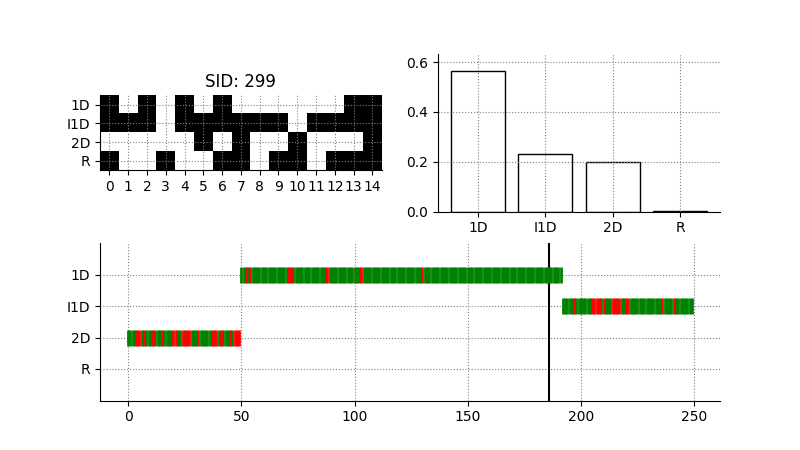

Button(button_style='info', description='Update initial state', style=ButtonStyle())

In [36]:
# from supplementary.simple_choice_model import sim_tools
simulator = sim_tools.Simulator(nb_trials=250, hits_generator=hits_generator, controls=True)